## Training
We have currently discussed the assessment of re-identification risk through the $k$-anonymity and the evaluation of data utility with respect to predictive performance, as well as the implementation of privacy-preserving techniques (PPTs) for safeguarding personal information. In this section, we will construct a pipeline with all steps of the de-identification process. The main steps for such a pipeline include:

- data analysis
- selection of proper QIs
- re-identification risk analysis
- predictive performance analysis
- PPTs application
- re-analysis of re-identification risk
- re-analysis of predictive performance

### Data analysis


For this training, we will use a data set about [cardiovascular disease](https://www.kaggle.com/datasets/captainozlem/framingham-chd-preprocessed-data). 

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
data = pd.read_csv("CHD_preprocessed.csv")

In [3]:
# Split the data: the original data will correspond to the training data, and test data will be used to analyze the predictive performance
X = data.loc[:,data.columns[:-1]]
y = data.loc[:,data.columns[-1]]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
173,0,60,1,0,0.0,0.0,0,1,0,325.0,182.0,106.0,27.61,80.0,77.0
1022,1,42,1,1,20.0,0.0,0,0,0,270.0,112.0,77.0,24.77,73.0,85.0
3182,1,58,0,0,0.0,0.0,0,0,0,225.0,105.5,74.0,25.68,50.0,93.0
331,0,58,0,0,0.0,0.0,0,1,0,200.0,158.0,101.0,23.06,85.0,77.0
2222,1,39,1,0,0.0,0.0,0,1,0,208.0,146.0,92.0,25.91,69.0,74.0


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 173 to 860
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3306 non-null   int64  
 1   age              3306 non-null   int64  
 2   education        3306 non-null   int64  
 3   currentSmoker    3306 non-null   int64  
 4   cigsPerDay       3306 non-null   float64
 5   BPMeds           3306 non-null   float64
 6   prevalentStroke  3306 non-null   int64  
 7   prevalentHyp     3306 non-null   int64  
 8   diabetes         3306 non-null   int64  
 9   totChol          3306 non-null   float64
 10  sysBP            3306 non-null   float64
 11  diaBP            3306 non-null   float64
 12  BMI              3306 non-null   float64
 13  heartRate        3306 non-null   float64
 14  glucose          3306 non-null   float64
dtypes: float64(8), int64(7)
memory usage: 413.2 KB


### QIs selection: *male, age,education, currentSmoker and diabetes*

In [6]:
X_train[['male', 'age', 'education', 'currentSmoker', 'diabetes']].describe()

,male,age,education,currentSmoker,diabetes
count,3306.000000,3306.000000,3306.000000,3306.000000,3306.000000
mean,0.423775,49.571385,0.283122,0.493043,0.023593
std,0.494230,8.543413,0.450583,0.500027,0.151802
min,0.000000,32.000000,0.000000,0.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000
75%,1.000000,56.000000,1.000000,1.000000,0.000000
max,1.000000,69.000000,1.000000,1.000000,1.000000


In [7]:
# Compute percentage of age
age_per = round((X_train['age'].value_counts()/X_train['age'].count())*100,2)
age_per = age_per.sort_index()

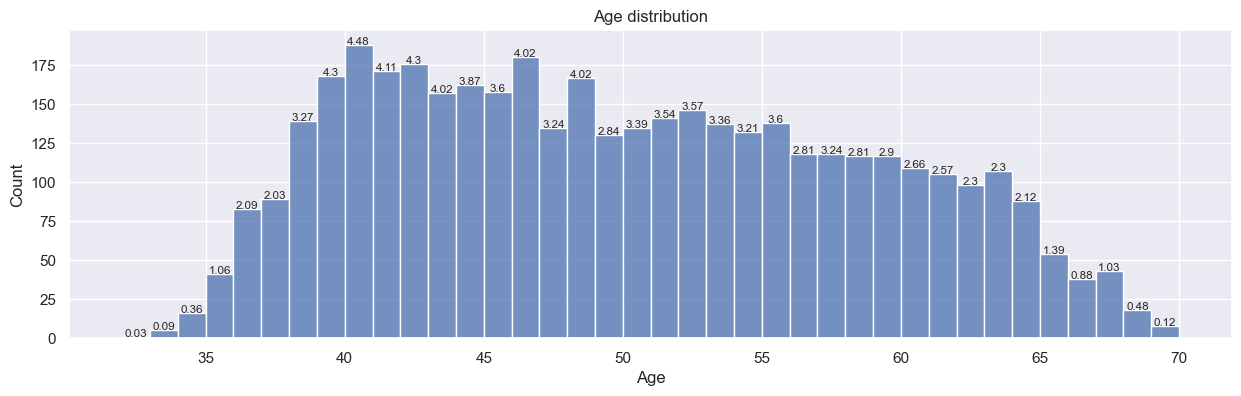

In [8]:
# Histplot of age
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data, x="age", bins=X_train['age'].nunique())
ax.set_xlabel('Age')
ax.set_title('Age distribution')
sns.set(font_scale=0.7)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        age_per.to_list()[i],ha="center")
    i += 1
plt.show()

Typically, the individuals at the tails of the curve are considered at risk as the concentration of individuals is lower.

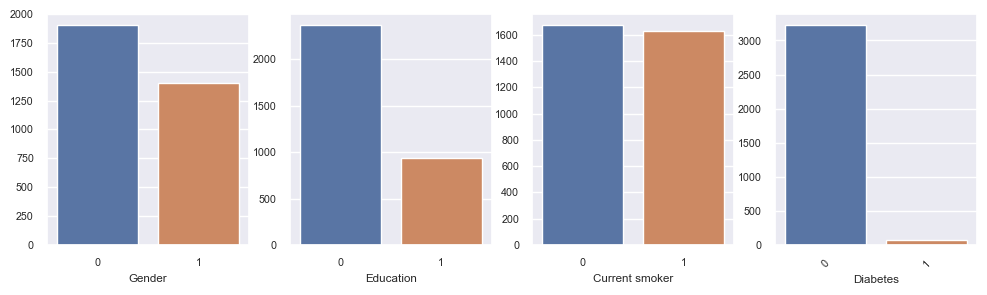

In [9]:
# Histplot for all binary QI
fig, axes = plt.subplots(1, 4, figsize=(12,3))
sns.countplot(ax=axes[0],data=X_train, x="male")
sns.countplot(ax=axes[1],data=X_train, x="education")
sns.countplot(ax=axes[2],data=X_train, x="currentSmoker")
sns.countplot(ax=axes[3],data=X_train, x="diabetes")
axes[0].set_xlabel("Gender")
axes[1].set_xlabel("Education")
axes[2].set_xlabel("Current smoker")
axes[3].set_xlabel("Diabetes")
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')
plt.xticks(rotation=45)
plt.show()

As fewer individuals have diabetes it is critical to protect their privacy!

### Initial re-identification risk

In [10]:
# Define a function to calculate the percentage of single outs concerning the selected QIs
def identity_risk(qi, df):
    '''
    Calculate the percentage of re-identification risk
    qi (list of strings): set of quasi-identifiers
    df (dataframe): data
    '''
    fk = df.groupby(qi)[qi[0]].transform('size')
    print('risk = ' + str(round((sum([i for i in fk if i==1]) * 100) / len(df),2))+ '%; fk1 = ' + str(sum([i for i in fk if i==1])))

In [11]:
identity_risk(['male', 'age'], X_train)

risk = 0.06%; fk1 = 2


In [12]:
# Analyze the cases in age and sex with fk=1
X_train.loc[(X_train.groupby(['male', 'age']).transform('size')==1)]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
2986,1,33,1,0,0.0,0.0,0,0,0,165.0,136.0,75.0,24.95,88.0,90.0
2304,0,32,0,1,15.0,0.0,0,0,0,242.0,111.0,70.0,29.84,80.0,88.0


In [13]:
identity_risk(['male', 'age', 'education'], X_train)

risk = 0.21%; fk1 = 7


In [14]:
identity_risk(['male', 'age', 'education', 'currentSmoker'], X_train)

risk = 0.45%; fk1 = 15


In [15]:
identity_risk(['male', 'age', 'education', 'currentSmoker', 'diabetes'], X_train)

risk = 1.97%; fk1 = 65


### Initial data utility w.r.t predictive performance

In [18]:
def modeling(X_train, X_test, y_train):
    '''
    Prediction with Random Forest
    df (Dataframe): data for modeling
    '''
    # encoded_data = pd.get_dummies(X_train, drop_first=True).astype(int)

    # Scale data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform (X_test)
    
    # Initiate models
    seed = np.random.seed(1234)
    xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)

    # Set parameters
    param_grid_xgb = {
        'n_estimators': [100, 250, 500],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.1, 0.01, 0.001]
    }
    
    # Fit the parameter grid with 5-fold cross validation
    gs_rf = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy').fit(X_train, y_train)
    
    # Predict on test data with best params
    y_pred = gs_rf.predict(X_test)
    
    return y_pred

In [19]:
initial_preds = modeling(X_train, X_test, y_train)

In [20]:
accuracy_score(y_test, initial_preds)

0.8234582829504232

### PPTs application


In [430]:
data_transf = X_train.copy().reset_index(drop=True)

In [431]:
# Apply generalization (global recoding)
def generalization(df, column, interval):
    '''
    Generalize integer attributes by applying the lowest value of the interval
    df: dataframe
    column (string): name of the column to transform
    interval (interger): limit of the interval 
    '''
    bins = list(range(min(df[column])-(min(df[column])%interval), max(df[column]) + interval, interval))
    labels = ['%d' % bins[i] for i in range(0, len(bins) - 1)]
    lab = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True).astype(int)
    for i in range(0, len(data_transf)):
        df.loc[i, column+str(interval)] = lab[i]
    return df

In [432]:
data_transf = generalization(data_transf, 'age', 2)

In [433]:
identity_risk(['male', 'age2'], data_transf)

risk = 0.0%; fk1 = 0


In [434]:
identity_risk(['male', 'age2', 'education'], data_transf)

risk = 0.06%; fk1 = 2


In [435]:
identity_risk(['male', 'age2', 'education', 'currentSmoker'], data_transf)

risk = 0.15%; fk1 = 5


In [436]:
identity_risk(['male', 'age2', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 1.33%; fk1 = 44


Given the fact of the majority of the QIs being binary, the best transformation is applying a higher generalization on *age*.

In [437]:
data_transf = generalization(data_transf, 'age', 3)

In [438]:
identity_risk(['male', 'age3', 'education'], data_transf)

risk = 0.06%; fk1 = 2


In [439]:
identity_risk(['male', 'age3', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 1.12%; fk1 = 37


In [440]:
# Increase the range
data_transf = generalization(data_transf, 'age', 5)
data_transf.age5 = data_transf.age5.apply(lambda x: int(x))

In [441]:
identity_risk(['male', 'age5', 'education'], data_transf)

risk = 0.0%; fk1 = 0


In [442]:
identity_risk(['male', 'age5', 'education', 'currentSmoker'], data_transf)

risk = 0.06%; fk1 = 2


In [443]:
identity_risk(['male', 'age5', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 0.73%; fk1 = 24


In [444]:
data_transf.loc[(data_transf.groupby(['male', 'age5', 'education', 'currentSmoker', 'diabetes']).transform('size')==1)]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,age2,age3,age5
12,0,43,0,0,0.0,0.0,0,1,1,231.0,155.5,99.5,34.95,68.0,274.0,42.0,42.0,40
135,1,49,0,0,0.0,0.0,0,0,1,248.0,130.5,82.0,27.29,52.0,254.0,48.0,48.0,45
208,1,66,0,1,30.0,0.0,0,0,1,234.0,114.5,62.5,28.62,75.0,216.0,64.0,63.0,65
314,1,33,1,0,0.0,0.0,0,0,0,165.0,136.0,75.0,24.95,88.0,90.0,32.0,30.0,30
796,1,44,0,0,0.0,0.0,0,1,1,208.0,175.0,101.0,27.93,95.0,193.0,42.0,42.0,40
869,1,66,1,1,20.0,0.0,0,1,0,273.0,145.0,88.0,25.41,69.0,74.0,64.0,63.0,65
927,1,64,1,0,0.0,0.0,0,0,1,251.0,133.0,72.5,24.28,65.0,86.0,62.0,63.0,60
941,0,39,1,0,0.0,0.0,0,0,1,209.0,104.0,72.0,23.96,90.0,103.0,38.0,36.0,35
959,1,45,1,0,0.0,0.0,0,0,1,189.0,132.0,78.0,28.40,75.0,177.0,44.0,42.0,40
1106,1,62,0,1,20.0,0.0,0,1,1,194.0,151.5,88.0,21.61,75.0,105.0,60.0,60.0,60


The highest risk sample corresponds to the individuals with diabetes, which is due to the smaller number of individuals with this health condition! Instead of suppressing all records, we can use **local recoding**, i.e., apply different levels of generalization to this set, namely higher levels. 

In [445]:
def local_recoding(df, column, interval, indexes):
    '''
    Local recoding by applying the lowest value of the interval
    df: dataframe
    column (string): name of the column to transform
    interval (interger): limit of the interval
    indexes (list of integers): list of indexes to recod
    '''
    bins = list(range(min(df[column])-(min(df[column])%interval), max(df[column]) + interval, interval))
    labels = ['%d' % bins[i] for i in range(0, len(bins) - 1)]
    lab = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True).astype(int)
    for i in range(0, len(data_transf)):
        if i in indexes:
            df.loc[i, column+'local'+str(interval)] = lab[i]
        else:
            df.loc[i, column+'local'+str(interval)] = df.loc[i, column]
    return df

In [446]:
indexes_to_recod_smoke= data_transf.loc[(data_transf.groupby(['male', 'age5', 'education', 'currentSmoker']).transform('size')==1)].index

In [447]:
indexes_to_recod_diabetes= data_transf.loc[(data_transf.groupby(['male', 'age5', 'education', 'currentSmoker', 'diabetes']).transform('size')==1)].index

In [465]:
# Join indexes in an unique list
indexes_to_recod = set(indexes_to_recod_diabetes.append(indexes_to_recod_smoke))

In [449]:
# Apply local recoding with an interval of 10
data_transf = local_recoding(data_transf, 'age5', 10, indexes_to_recod)
data_transf.age5local10 = data_transf.age5local10.apply(lambda x: int(x))

In [450]:
identity_risk(['male', 'age5local10', 'education', 'currentSmoker'], data_transf)

risk = 0.0%; fk1 = 0


In [451]:
identity_risk(['male', 'age5local10', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 0.39%; fk1 = 13


In [452]:
data_transf.loc[(data_transf.groupby(['male', 'age5local10', 'education', 'currentSmoker', 'diabetes']).transform('size')==1)]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,age2,age3,age5,age5local10
12,0,43,0,0,0.0,0.0,0,1,1,231.0,155.5,99.5,34.95,68.0,274.0,42.0,42.0,40,30
135,1,49,0,0,0.0,0.0,0,0,1,248.0,130.5,82.0,27.29,52.0,254.0,48.0,48.0,45,40
208,1,66,0,1,30.0,0.0,0,0,1,234.0,114.5,62.5,28.62,75.0,216.0,64.0,63.0,65,60
314,1,33,1,0,0.0,0.0,0,0,0,165.0,136.0,75.0,24.95,88.0,90.0,32.0,30.0,30,30
796,1,44,0,0,0.0,0.0,0,1,1,208.0,175.0,101.0,27.93,95.0,193.0,42.0,42.0,40,30
959,1,45,1,0,0.0,0.0,0,0,1,189.0,132.0,78.0,28.40,75.0,177.0,44.0,42.0,40,30
1176,0,50,1,1,9.0,0.0,0,0,1,210.0,134.0,80.0,18.26,64.0,82.0,48.0,48.0,45,40
2103,1,57,1,1,15.0,0.0,0,0,1,245.0,132.0,77.0,23.01,76.0,207.0,56.0,54.0,55,50
2163,0,40,0,1,20.0,0.0,0,0,1,237.0,114.0,65.0,21.19,61.0,82.0,38.0,39.0,35,30
2220,1,52,1,1,35.0,0.0,0,1,1,281.0,133.0,93.0,32.27,115.0,80.0,50.0,51.0,50,40


In [453]:
data_transf = local_recoding(data_transf, 'age5', 15, indexes_to_recod)
data_transf.age5local15 = data_transf.age5local15.apply(lambda x: int(x))

In [454]:
identity_risk(['male', 'age5local15', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 0.27%; fk1 = 9


Increasing even more the range of *age*, will result in a higher information loss without a relevant reduction in re-identification risk! Let's keep local recoding with an interval of 10.

In [455]:
identity_risk(['male', 'age5local10', 'education', 'currentSmoker'], data_transf)

risk = 0.0%; fk1 = 0


In [456]:
identity_risk(['male', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 0.0%; fk1 = 0


In [457]:
identity_risk(['male', 'age5local10', 'diabetes'], data_transf)

risk = 0.0%; fk1 = 0


As the re-identification risk only increases with the addition of *diabetes* to the remaining QIs, we can suppress the values that are at risk for this attribute.

In [458]:
indexes_to_remove = data_transf.loc[(data_transf.groupby(['male', 'age5local10', 'education', 'currentSmoker', 'diabetes']).transform('size')==1)].index

In [459]:
data_transf['diabetes'] = np.where(np.isin(data_transf.index, indexes_to_remove), np.nan, data_transf['diabetes'])

In [466]:
identity_risk(['male', 'age5local10', 'education', 'currentSmoker', 'diabetes'], data_transf)

risk = 0.0%; fk1 = 0


In [460]:
# Replace the original attributes with the transformed values
final_data = X_train.copy().reset_index(drop=True)
final_data['age'] = data_transf['age5local10']
final_data['diabetes'] = data_transf['diabetes']

In [461]:
# Predictive performance for the transformed data
transf_preds = modeling(final_data, X_test, y_train)

In [462]:
accuracy_score(y_test, transf_preds)

0.8222490931076178

Let's find the losses for predictive performance by calculating the percentage difference between the original and the transformed data.

$(R_a - R_b) / R_b * 100$, where a is the transformed and $b$ is the baseline (original result)

In [464]:
(0.8222490931076178 - 0.8234582829504232) / 0.8234582829504232 *100

-0.14684287812041844

With an interval of 5 in *age* for the majority of the records, local recoding of range 10 and suppression for a small part of the data, we obtain an information loss of 0.14%, which it seems to be an aceptable loss given the reduction in re-identification risk.

### Additional notes

- **QIs selection**
    - Althoug we lected a set of QIs for privacy risk analysis, the information that an intruder may posses is unkown, and thus it is **crucial** to simulate several scenarios of a potential re-identification attack;
- **PPTs application**
    - Lower generalization intervals allows maintaining data utility more closer to the original;
    - Suppression causes higher information losses, therefore should be used as a last alternative;
    - Applying suppression in a numerical attribute using '*' will transform it into a categorical attribute, but using NaN could be a problem to analyze predicitve performance as it is not accepted for many machine learning models;
    - $k$-anonymity is not the best choice to evaluate the risk for perturbative techniques or synthetic data;
- **Evaluation**
    - Achieving a re-identification risk of 0% is difficult and often comes at a huge cost in utility;
    - It is probable that a *residual risk* of re-identification still remains after the transformations;
    - The *residual risk* should be carefully analyzed to determine whether we can take the inherent risks of sharing or publishing the data;
    - Different privacy measures should be used for a better privacy risk evaluation.

In [ ]:
# How to add noise
'''
noise = randint(-2,2, len(data_transf))
data_transf[column_transf] = data_transf[column]

for i in range(0, len(data_transf)):
    if noise[i] != 0:
        data_transf.loc[i, column_transf] = data_transf.loc[i, column] + noise[i]    
'''